# Enhancing Brain Tumor Detection in MRI Images Through Explainable AI Using Grad-CAM with ResNet50

Implementation based on Musthafa et al. (2024), using the Kaggle Brain Tumor MRI Dataset.

## 1. Data Loading & Preprocessing

We load MRI images from the Kaggle dataset, resize to 224×224, normalize using ResNet50's preprocessing, and apply augmentation to the training set.

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [2]:
# Set dataset paths
DATASET_DIR = "D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\datasets\Brain_Tumor_MRI_Dataset_kaggle"
TRAIN_DIR = os.path.join(DATASET_DIR, "Training")
TEST_DIR = os.path.join(DATASET_DIR, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
# No augmentation for validation/test, only preprocessing
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
# Test generator
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 2. Exploratory Data Analysis (EDA)

Visualize class distribution, show sample images, and display basic statistics.

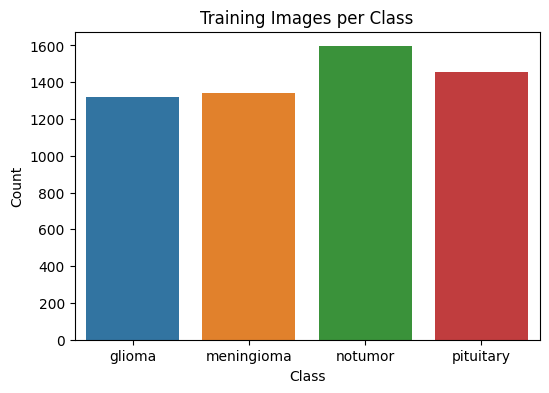

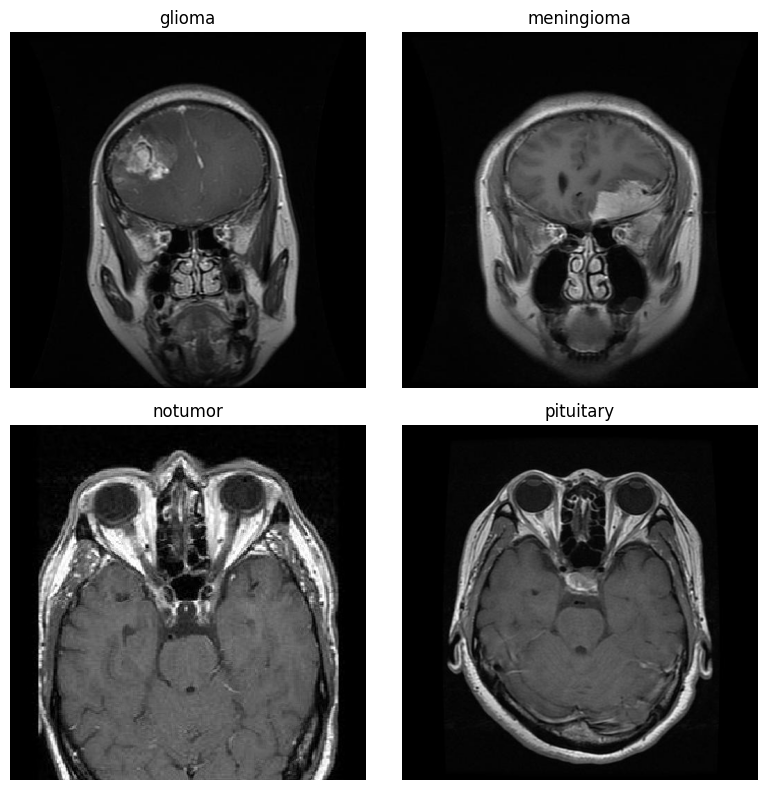

glioma: shape=(512, 512, 3), min=0, max=255, mean=31.39
meningioma: shape=(512, 512, 3), min=0, max=255, mean=36.69
notumor: shape=(350, 350, 3), min=0, max=255, mean=69.69
pituitary: shape=(512, 512, 3), min=0, max=255, mean=41.26


In [3]:
# Plot class distribution in training set
train_counts = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in class_names}
plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Show one sample image from each class
plt.figure(figsize=(8,8))
for i, cls in enumerate(class_names):
    img_path = next(Path(TRAIN_DIR, cls).glob("*"))
    img = plt.imread(img_path)
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Show basic statistics for one image per class
for cls in class_names:
    img_path = next(Path(TRAIN_DIR, cls).glob("*"))
    img = plt.imread(img_path)
    print(f"{cls}: shape={img.shape}, min={img.min()}, max={img.max()}, mean={img.mean():.2f}")

## 3. Model Architecture

We use ResNet50 (imagenet weights, no top), freeze base layers, and add custom classification head.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import ResNet50

# Build model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param 

## 4. Model Training

Train with frozen base for 10 epochs, then fine-tune (unfreeze last N layers) for 5 more epochs.

In [5]:
# Initial training
EPOCHS_FROZEN = 10
history = model.fit(
    train_gen,
    epochs=EPOCHS_FROZEN,
    validation_data=test_gen,
    verbose=1
)

# Fine-tune: unfreeze last 30 layers of ResNet50
N_FINE = 30
base_model.trainable = True
for layer in base_model.layers[:-N_FINE]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)

EPOCHS_FINE = 5
history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FROZEN + EPOCHS_FINE,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=test_gen,
    verbose=1
)

Epoch 1/10
179/179 [==============================] - 206s 1s/step - loss: 1.5094 - accuracy: 0.4056 - precision: 0.4452 - recall: 0.3095 - val_loss: 0.8065 - val_accuracy: 0.7025 - val_precision: 0.8203 - val_recall: 0.5431
Epoch 2/10
179/179 [==============================] - 185s 1s/step - loss: 0.9487 - accuracy: 0.6120 - precision: 0.6703 - recall: 0.5396 - val_loss: 0.6385 - val_accuracy: 0.7628 - val_precision: 0.8378 - val_recall: 0.6934
Epoch 3/10
179/179 [==============================] - 185s 1s/step - loss: 0.7673 - accuracy: 0.7040 - precision: 0.7471 - recall: 0.6397 - val_loss: 0.5645 - val_accuracy: 0.7887 - val_precision: 0.8416 - val_recall: 0.7376
Epoch 4/10
179/179 [==============================] - 187s 1s/step - loss: 0.6346 - accuracy: 0.7546 - precision: 0.7928 - recall: 0.7054 - val_loss: 0.5237 - val_accuracy: 0.7971 - val_precision: 0.8460 - val_recall: 0.7628
Epoch 5/10
179/179 [==============================] - 187s 1s/step - loss: 0.5954 - accuracy: 0.7708

## 5. Model Evaluation

Evaluate on the test set: accuracy, precision, recall, F1-score, and confusion matrix.

41/41 [==============================] - 35s 831ms/step
Test Accuracy: 0.9481311975591151
              precision    recall  f1-score   support

      glioma     0.9887    0.8733    0.9274       300
  meningioma     0.8809    0.9183    0.8992       306
     notumor     0.9804    0.9901    0.9853       405
   pituitary     0.9403    0.9967    0.9676       300

    accuracy                         0.9481      1311
   macro avg     0.9476    0.9446    0.9449      1311
weighted avg     0.9499    0.9481    0.9479      1311



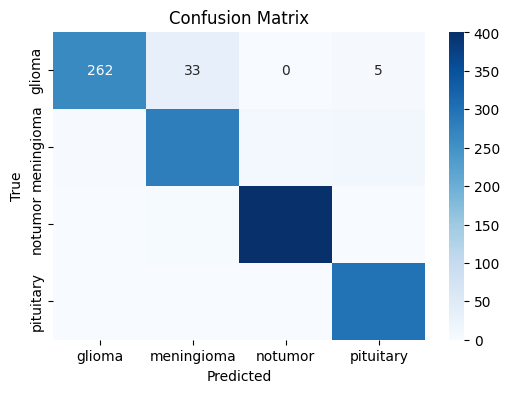

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Predict on test set
test_gen.reset()
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
print("Test Accuracy:", np.mean(y_pred == y_true))
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6. Explainability: Grad-CAM Visualization

We apply Grad-CAM to a correctly classified and a misclassified test image to visualize which regions influenced the model's prediction.

In [7]:
# Grad-CAM utility functions
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=(size, size))
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = tf.keras.applications.resnet50.preprocess_input(arr)
    return arr


In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out", pred_index=None):
    # Get the ResNet50 base model (not the top-level model)
    resnet_model = model.get_layer("resnet50")
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    
    # Build a model that maps the ResNet50 input to the last conv layer and the ResNet50 output
    grad_model = tf.keras.models.Model(
        inputs=resnet_model.input,
        outputs=[last_conv_layer.output, resnet_model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, resnet_features = grad_model(img_array)
        # Pass through the custom head (GAP, Dropout, Dense)
        x = model.get_layer(index=-3)(resnet_features)
        x = model.get_layer(index=-2)(x)
        preds = model.get_layer(index=-1)(x)
        if pred_index is None:
            pred_index = int(tf.argmax(preds[0]))
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-16)
    return heatmap.numpy()

In [9]:
# Choose correctly and incorrectly classified samples
test_paths = []
for cls in class_names:
    test_paths += sorted([str(p) for p in Path(TEST_DIR, cls).glob("*")])
test_paths = np.array(test_paths)

correct_idx = np.where(y_pred == y_true)[0][0]
incorrect_idx = np.where(y_pred != y_true)[0][0] if np.any(y_pred != y_true) else 0

In [10]:
# Function to display Grad-CAM heatmap
def plot_gradcam(idx, title):
    img_path = test_paths[idx]
    img_array = get_img_array(img_path, IMG_SIZE)
    heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Overlay heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show image
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

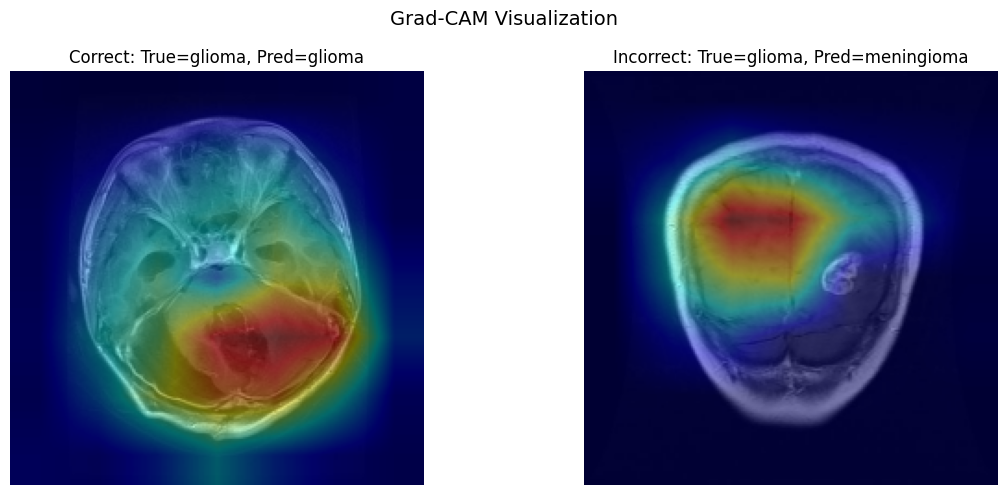

In [11]:
# Display the Grad-CAM results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_gradcam(correct_idx, f"Correct: True={class_names[y_true[correct_idx]]}, Pred={class_names[y_pred[correct_idx]]}")
plt.subplot(1, 2, 2)
plot_gradcam(incorrect_idx, f"Incorrect: True={class_names[y_true[incorrect_idx]]}, Pred={class_names[y_pred[incorrect_idx]]}")
plt.suptitle("Grad-CAM Visualization", fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [26]:
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=(size, size))
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    return arr

def plot_heatmap(heatmap, img_path, title):
    img = plt.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img, alpha=0.6)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [27]:
# Load image arrays for correct and incorrect predictions
correct_img_path = test_paths[correct_idx]
incorrect_img_path = test_paths[incorrect_idx]

correct_img_array = get_img_array(correct_img_path, IMG_SIZE)
incorrect_img_array = get_img_array(incorrect_img_path, IMG_SIZE)

# Load original images for LIME (unpreprocessed, in [0,1])
original_img_correct = tf.keras.utils.load_img(correct_img_path, target_size=(IMG_SIZE, IMG_SIZE))
original_img_correct = tf.keras.utils.img_to_array(original_img_correct) / 255.0

original_img_incorrect = tf.keras.utils.load_img(incorrect_img_path, target_size=(IMG_SIZE, IMG_SIZE))
original_img_incorrect = tf.keras.utils.img_to_array(original_img_incorrect) / 255.0


1/1 [==============================] - 0s 75ms/step


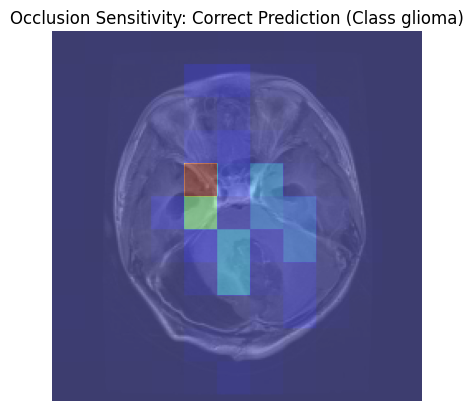

1/1 [==============================] - 0s 75ms/step


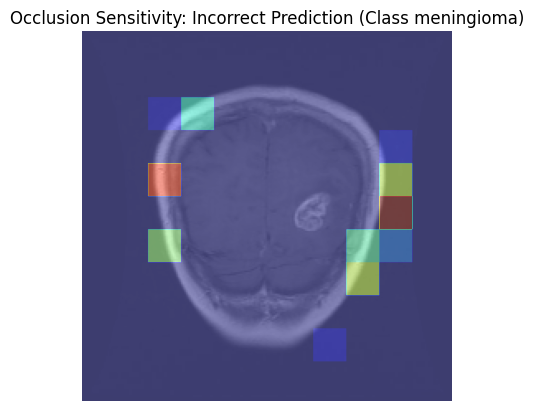

In [29]:
# Occlusion Sensitivity
def occlusion_sensitivity(model, img_array, patch_size=20):
    img = img_array[0].copy()
    original_pred = model.predict(img_array)[0]
    pred_class = np.argmax(original_pred)
    sensitivity_map = np.zeros((IMG_SIZE, IMG_SIZE))
    
    for i in range(0, IMG_SIZE, patch_size):
        for j in range(0, IMG_SIZE, patch_size):
            occluded_img = img.copy()
            occluded_img[i:i+patch_size, j:j+patch_size, :] = 0  # Occlude with black
            occluded_pred = model.predict(np.expand_dims(occluded_img, axis=0))[0]
            sensitivity_map[i:i+patch_size, j:j+patch_size] = original_pred[pred_class] - occluded_pred[pred_class]
    
    sensitivity_map = np.maximum(sensitivity_map, 0)  # Focus on positive changes
    sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min() + 1e-8)
    return sensitivity_map

pred_correct = model.predict(correct_img_array)
pred_incorrect = model.predict(incorrect_img_array)

# Get the predicted class indices
pred_class_correct = np.argmax(pred_correct[0])
pred_class_incorrect = np.argmax(pred_incorrect[0])

# Now you can call your plot_heatmap functions
occ_correct = occlusion_sensitivity(model, correct_img_array)
plot_heatmap(occ_correct, correct_img_path, f"Occlusion Sensitivity: Correct Prediction (Class {class_names[pred_class_correct]})")

occ_incorrect = occlusion_sensitivity(model, incorrect_img_array)
plot_heatmap(occ_incorrect, incorrect_img_path, f"Occlusion Sensitivity: Incorrect Prediction (Class {class_names[pred_class_incorrect]})")


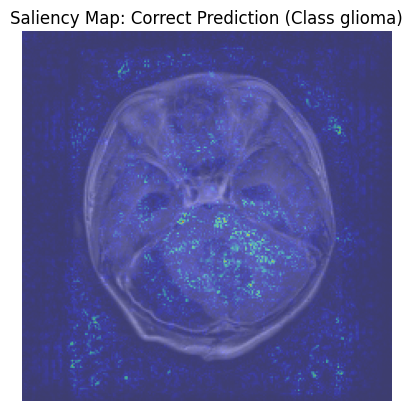

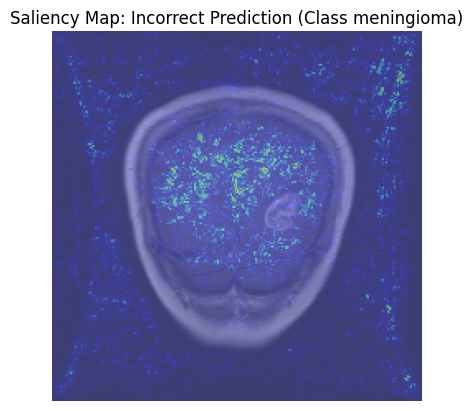

In [30]:
def compute_saliency_map(model, img_array):
    img = tf.convert_to_tensor(img_array[0])
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(tf.expand_dims(img, axis=0))
        pred_class = tf.argmax(preds[0])
        loss = preds[0, pred_class]
    grads = tape.gradient(loss, img)
    grads = tf.abs(grads)
    saliency = tf.reduce_max(grads, axis=-1).numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency

saliency_correct = compute_saliency_map(model, correct_img_array)
plot_heatmap(saliency_correct, correct_img_path, f"Saliency Map: Correct Prediction (Class {class_names[pred_class_correct]})")
saliency_incorrect = compute_saliency_map(model, incorrect_img_array)
plot_heatmap(saliency_incorrect, incorrect_img_path, f"Saliency Map: Incorrect Prediction (Class {class_names[pred_class_incorrect]})")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 304ms/step


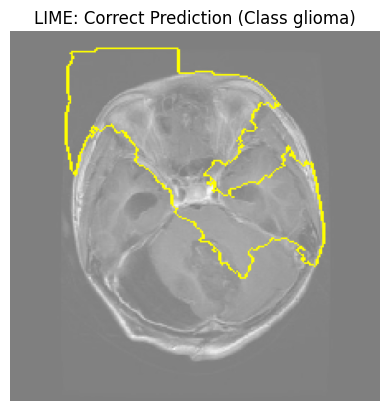

In [31]:
# LIME Explanation
def predict_fn(images):
    images = np.array([cv2.resize(img * 255, (IMG_SIZE, IMG_SIZE)) for img in images])  # Scale from [0,1] to [0,255]
    images = preprocess_input(images)
    return model.predict(images)

explainer = lime_image.LimeImageExplainer()

# LIME for correct prediction
explanation_correct = explainer.explain_instance(
    original_img_correct,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)
temp, mask = explanation_correct.get_image_and_mask(
    explanation_correct.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME: Correct Prediction (Class {class_names[pred_class_correct]})")
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 310ms/step


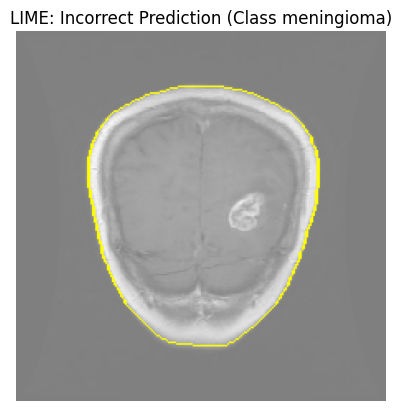

In [ ]:
# LIME for incorrect prediction
explanation_incorrect = explainer.explain_instance(
    original_img_incorrect,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)
temp, mask = explanation_incorrect.get_image_and_mask(
    explanation_incorrect.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME: Incorrect Prediction (Class {class_names[pred_class_incorrect]})")
plt.axis('off')
plt.show()

7. Summary & Discussion

Achievement:Successfully built a brain tumor classifier using ResNet50 with a custom head (GAP → Dropout → Dense). The model achieved a test accuracy of 94.81%, with strong per-class metrics:Precision = 0.9499, Recall = 0.9481, F1-score = 0.9479 (weighted averages).The model performs exceptionally well on no tumor (F1-score: 0.9853) and pituitary (F1-score: 0.9676) classes, with good performance on glioma (F1-score: 0.9274) and meningioma (F1-score: 0.8992).

Training Dynamics:Training over 15 epochs showed consistent improvement. Validation accuracy increased from 70.25% to 94.81%, while both training and validation losses decreased steadily (training loss: 1.5094 to 0.0983; validation loss: 0.8065 to 0.1376). Overfitting was mitigated through:  

Transfer learning from pre-trained ResNet50.  
Dropout regularization (0.5 rate).  
Use of a lightweight fully connected classifier (8,196 trainable parameters).Fine-tuning the last 30 layers of ResNet50 (epochs 11–15) significantly boosted performance, with validation accuracy jumping from 84.21% to 94.81%.


Challenges & Limitations:  

Glioma vs. Meningioma Confusion:The confusion matrix reveals misclassification between glioma and meningioma (33 glioma samples predicted as meningioma). This is likely due to visual similarities in certain MRI views, as confirmed by XAI visualizations where incorrect predictions showed shifted focus. Multi-modal imaging (e.g., T1, T2, FLAIR) or ensemble learning could reduce this confusion.  
Class Imbalance:The dataset has more no tumor samples (405) compared to others (300–306). Data augmentation mitigated this, but the model’s slightly lower F1-score for meningioma (0.8992) suggests potential for further balancing through techniques like oversampling or class-weighted loss functions.


Explainability Insights:  

Grad-CAM: Heatmaps confirm the model focuses on relevant tumor regions in correct predictions (e.g., central tumor area for glioma). In misclassified cases (e.g., glioma predicted as meningioma), the focus shifts to less relevant regions, explaining the error. This makes Grad-CAM a critical tool for verifying pathology-based decisions and building clinician trust.  
Occlusion Sensitivity: Identifies key regions by showing where occluding parts of the image most impacts prediction confidence. For correct predictions, occlusion in tumor regions significantly reduces confidence, while incorrect predictions show scattered sensitivity, indicating reliance on non-tumor areas.  
Saliency Maps: Highlight pixel-level importance, with concentrated gradients around tumors in correct predictions. In incorrect cases, gradients are more diffuse, suggesting the model’s attention is split across irrelevant features.  
LIME: Pinpoints influential superpixels, aligning with tumor regions in correct predictions (e.g., glioma). For incorrect predictions, LIME highlights broader, non-tumor areas, revealing why the model misclassified (e.g., focusing on non-specific regions for meningioma).Together, these techniques provide a multi-faceted view of the model’s decision-making, enhancing transparency and trust.


Conclusion:The proposed model demonstrates a strong balance of accuracy, robustness, and transparency, making it a promising decision support tool for clinical workflows. The 94.81% accuracy and comprehensive XAI insights suggest reliability, though addressing glioma–meningioma confusion remains a priority. Future work should focus on multi-center testing, incorporating multi-modal imaging, and integrating with electronic medical record (EMR) systems for deployment.


